# 2.- Lightweight MMM

In [1]:
import numpy as np
import pandas as pd
import jax.numpy as jnp

from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [2]:
# Load your dataset
df = pd.read_csv("../data/bike_sales_data.csv", index_col="Week")
df.index = pd.to_datetime(df.index, format='mixed')
df

,sales,branded_search_spend,nonbranded_search_spend,facebook_spend,print_spend,ooh_spend,tv_spend,radio_spend
Week,,,,,,,,
2017-07-23,58850.0000,1528.80,463.3200,802.6200,0,0,0,0
2017-07-30,62050.0000,1575.60,468.0000,819.3120,0,0,0,0
2017-08-06,59388.0000,1544.40,477.3600,749.0340,0,0,0,0
2017-08-13,56964.0000,1528.80,468.0000,741.4680,0,0,0,0
2017-08-20,53460.0000,1560.00,458.6400,811.2000,0,0,0,0
...,...,...,...,...,...,...,...,...
2022-06-12,98173.4880,3466.32,814.9285,1715.8284,1000,0,2500,0
2022-06-19,104221.7248,3534.96,829.0855,1802.8296,0,0,2500,0
2022-06-26,103283.6800,3363.36,793.6930,1631.2296,0,0,2500,0


In [5]:
class LightweightMMM:
    
    def __init__(self,
                 maestro_df,
                 kpi_column_name,
                 media_columns_patter,
                 test_size,
                 model_name,
                 SEED
                 ):
        
        self.data_raw = maestro_df
        self.kpi_column_name = kpi_column_name
        self.media_columns_patter = media_columns_patter
        
        self.media_names = self.set_media_names()

        self.kpi_df = self.set_kpi_df()
        self.media_df = self.set_media_df()
        self.costs_df = self.set_costs_df()
  
        self.kpi_np = self.set_kpi_np()
        self.media_np = self.set_media_np()
        self.costs_np = self.set_costs_np()

        self.test_size = test_size

        self.data_split = self.set_split_data()
        self.data_scalers = self.set_scalers()

        self.model_name = model_name
        self.SEED = SEED

        self.mmm_model = self.fitting()

    def set_media_names(self):
        return self.data_raw.loc[
            :, self.data_raw.columns.to_series(
            ).str.contains(self.media_columns_patter)].columns
    
    def set_kpi_df(self):
        return self.data_raw[self.kpi_column_name]
    
    def set_media_df(self):
        return self.data_raw[self.media_names]
    
    def set_costs_df(self):
        return self.media_df.sum()
    
    def set_kpi_np(self):
        return self.kpi_df.to_numpy()
    
    def set_media_np(self):
        return self.media_df.to_numpy()
    
    def set_costs_np(self):
        return self.costs_df.to_numpy()
    
    def set_split_data(self):
        
        data_size = len(self.data_raw)
        test_data_period_size = int(data_size * self.test_size)
        split_point = data_size - test_data_period_size

        return {
            'media_data_train' :  self.media_np[:split_point, ...],
            'media_data_test' :  self.media_np[split_point:, ...],
            'kpi_data_train' :  self.kpi_np[:split_point],
            'kpi_data_test' :  self.kpi_np[split_point:],
            }
    
    def set_scalers(self):
    
        media_scaler = preprocessing.CustomScaler(
            divide_operation=jnp.mean)
        kpi_scaler = preprocessing.CustomScaler(
            divide_operation=jnp.mean)
        cost_scaler = preprocessing.CustomScaler(
            divide_operation=jnp.mean, multiply_by=0.15)

        kpi_scaler.fit(self.kpi_np)
        media_scaler.fit(self.media_np)
        
        costs_scaled = cost_scaler.fit_transform(self.costs_np)

        media_data_train_scaled = media_scaler.transform(
            self.data_split['media_data_train'])
        kpi_data_train_scaled = kpi_scaler.transform(
            self.data_split['kpi_data_train'])

        media_data_test_scaled = media_scaler.transform(
            self.data_split['media_data_test'])
        kpi_data_test_scaled = kpi_scaler.transform(
            self.data_split['kpi_data_test'])
        
        return {
            'media_scaler' : media_scaler,
            'kpi_scaler' : kpi_scaler,
            'costs_scaler' : cost_scaler,

            'media_data_train_scaled' :  np.nan_to_num(
            media_data_train_scaled, nan=0.0),
            'kpi_data_train_scaled' :  np.nan_to_num(
            kpi_data_train_scaled, nan=0.0),

            'media_data_test_scaled' :  np.nan_to_num(
            media_data_test_scaled, nan=0.0),
            'kpi_data_test_scaled' :  np.nan_to_num(
            kpi_data_test_scaled, nan=0.0),

            'costs_scaled' :  np.nan_to_num(
            costs_scaled, nan=0.0),
            }
    
    def fitting(self):
        
        mmm = lightweight_mmm.LightweightMMM(model_name=self.model_name)
        
        mmm.fit(media = self.data_scalers['media_data_train_scaled'],
                media_prior = self.data_scalers['costs_scaled'],
                target = self.data_scalers['kpi_data_train_scaled'],
                number_warmup=1000,
                number_samples=1000,
                number_chains=1,
                media_names = self.media_names,
                degrees_seasonality=12,
                seed = self.SEED
                )
        
        return mmm

## Training

In [14]:
LightweightMMM_instance = LightweightMMM(df, 'sales', 'spend',
                                         0.2, 'hill_adstock', 127)

sample: 100%|██████████| 2000/2000 [00:18<00:00, 108.72it/s, 26 steps of size 4.17e-02. acc. prob=0.78]


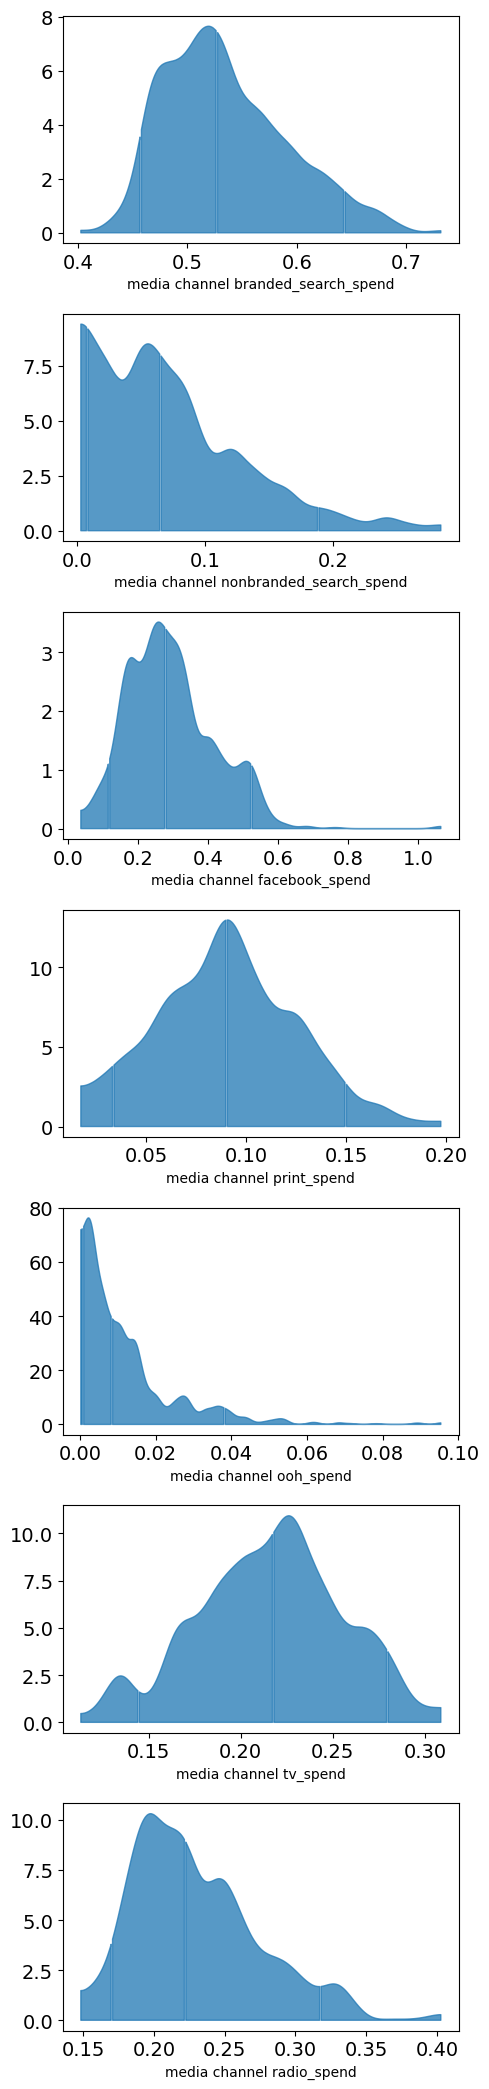

In [30]:
plot.plot_media_channel_posteriors(media_mix_model=LightweightMMM_instance.mmm_model, 
                                   channel_names=LightweightMMM_instance.media_names)

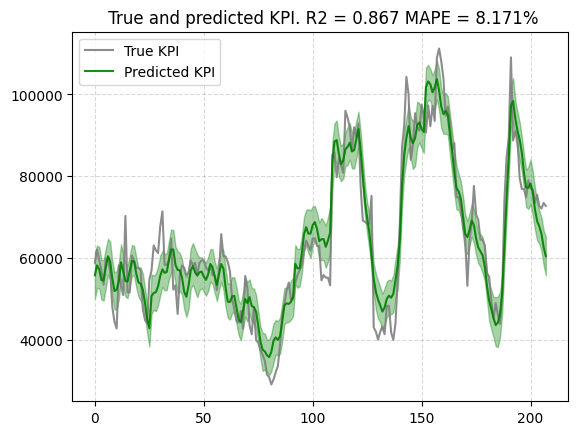

In [15]:
plot.plot_model_fit(LightweightMMM_instance.mmm_model,
                    target_scaler=LightweightMMM_instance.data_scalers['kpi_scaler'])

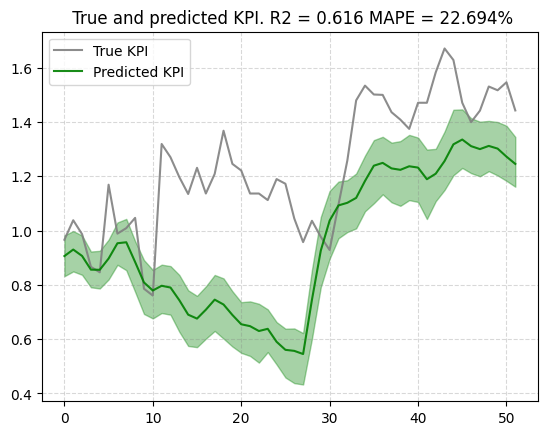

In [16]:
# Predictions on test set
prediction = LightweightMMM_instance.mmm_model.predict(
    media=LightweightMMM_instance.data_scalers['media_data_test_scaled'],
    seed=127
)
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=prediction,
                                  out_of_sample_target=LightweightMMM_instance.data_scalers['kpi_data_test_scaled'])

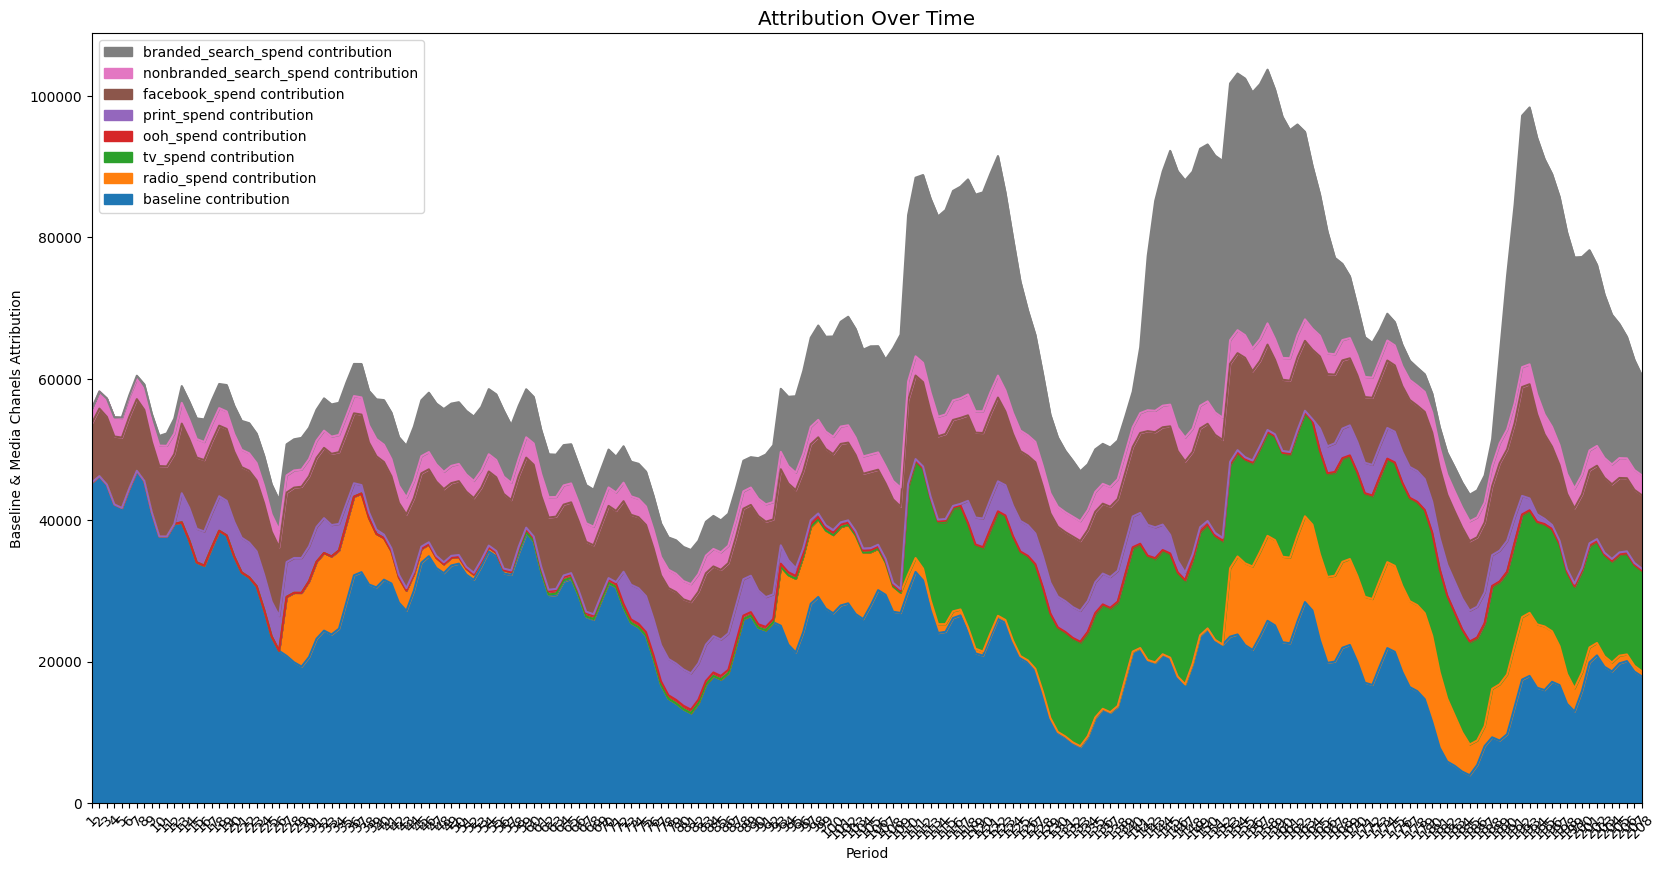

In [17]:
plot.plot_media_baseline_contribution_area_plot(
        media_mix_model = LightweightMMM_instance.mmm_model,
        target_scaler = LightweightMMM_instance.data_scalers['kpi_scaler'],
        fig_size = (20, 10),
        channel_names = LightweightMMM_instance.media_names)

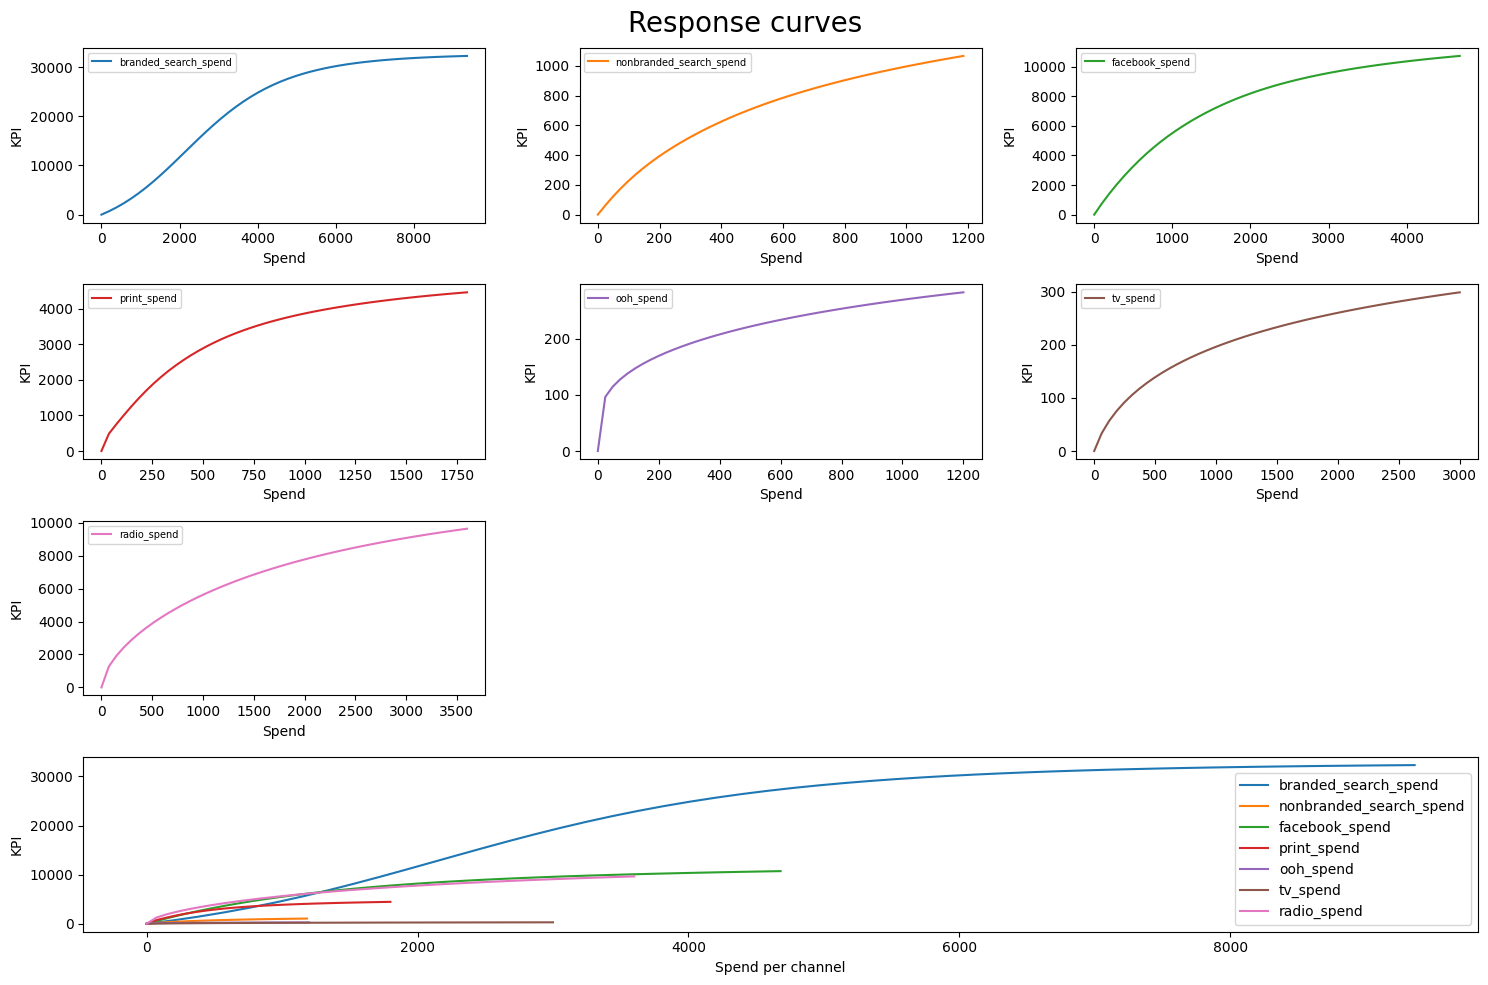

In [32]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=".*is_categorical_dtype.*")

plot.plot_response_curves(media_mix_model=LightweightMMM_instance.mmm_model,
                          media_scaler=LightweightMMM_instance.data_scalers['media_scaler'],
                          target_scaler=LightweightMMM_instance.data_scalers['kpi_scaler'],
                          figure_size= (15, 10),
                          n_columns = 3,
                          marker_size= 5,
                          legend_fontsize = 7)

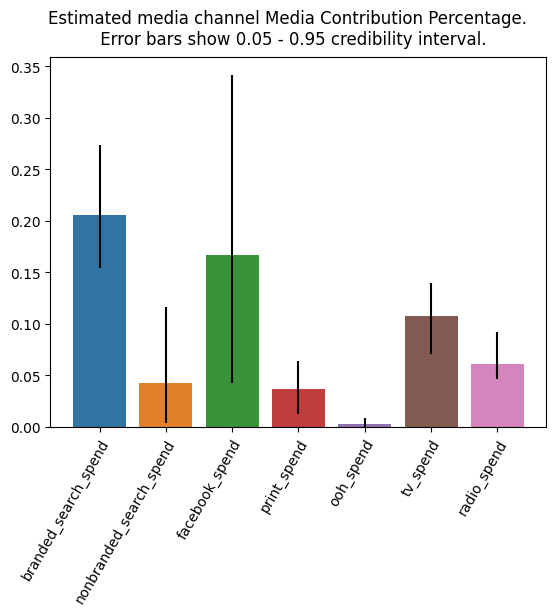

In [18]:
media_contribution, roi_hat = LightweightMMM_instance.mmm_model.get_posterior_metrics(
    target_scaler=LightweightMMM_instance.data_scalers['kpi_scaler'],
    cost_scaler=LightweightMMM_instance.data_scalers['costs_scaler'])


plot.plot_bars_media_metrics(metric=media_contribution,
                             metric_name="Media Contribution Percentage",
                             channel_names=LightweightMMM_instance.media_names)

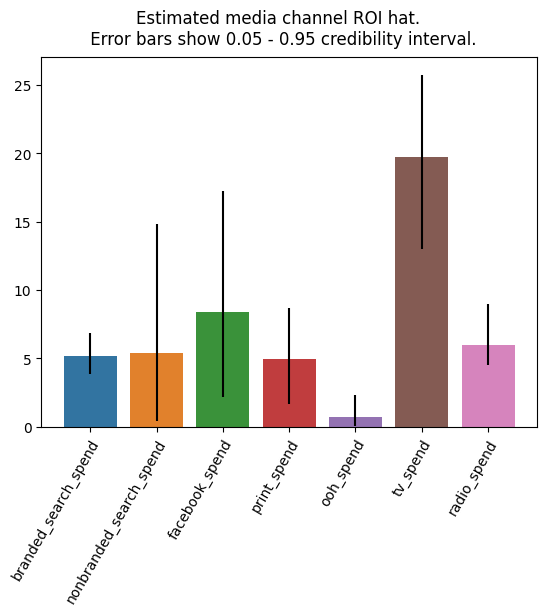

In [19]:
plot.plot_bars_media_metrics(metric=roi_hat,
                             metric_name="ROI hat",
                             channel_names=LightweightMMM_instance.media_names)

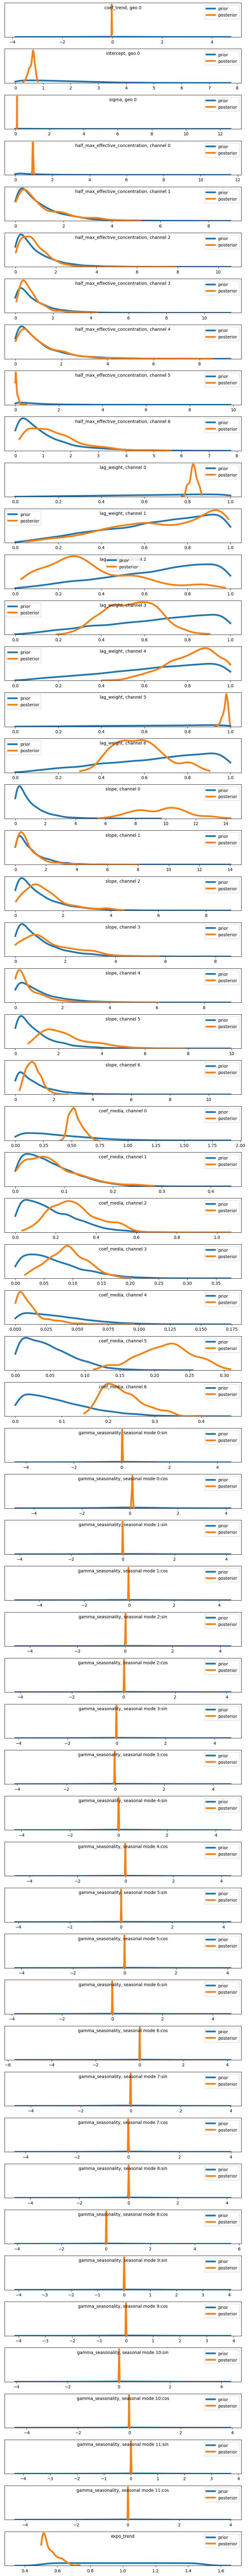

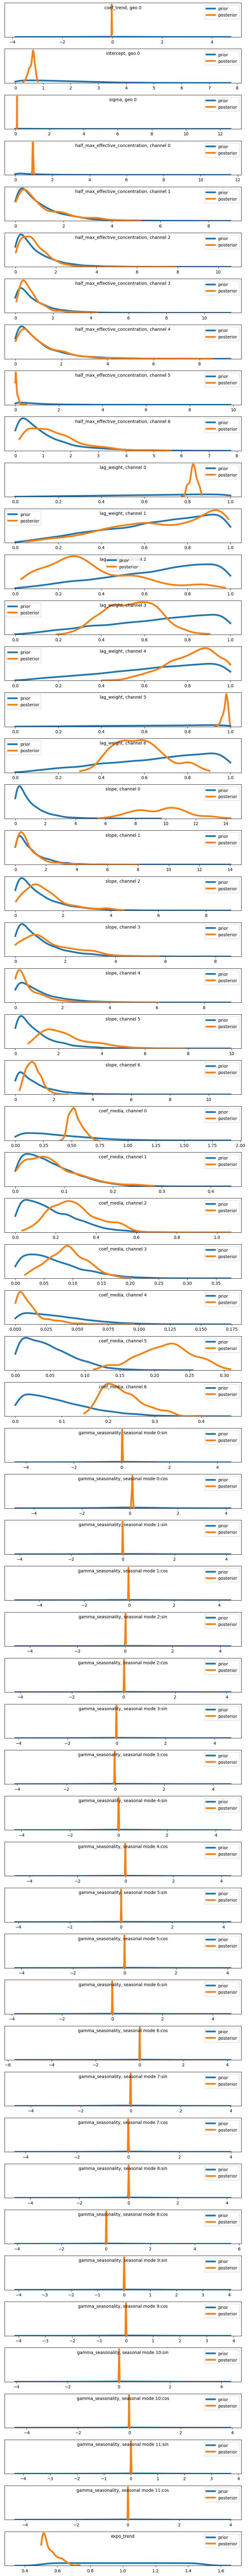

In [31]:
plot.plot_prior_and_posterior(media_mix_model=LightweightMMM_instance.mmm_model)

In [22]:
prices = jnp.ones(LightweightMMM_instance.mmm_model.n_media_channels)
n_time_periods = 10
budget = sum(LightweightMMM_instance.media_np.mean(axis=0) * n_time_periods)

In [33]:
# Run optimization with the parameters of choice.
solution, kpi_without_optim, previous_media_allocation = optimize_media.find_optimal_budgets(
    n_time_periods=n_time_periods,
    media_mix_model=LightweightMMM_instance.mmm_model,
    budget=budget,
    prices=prices,
    media_scaler=LightweightMMM_instance.data_scalers['media_scaler'],
    target_scaler=LightweightMMM_instance.data_scalers['kpi_scaler'],
    bounds_lower_pct=0.5,
    bounds_upper_pct=0.5,
    seed=127)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -888645.5077534695
            Iterations: 33
            Function evaluations: 495
            Gradient evaluations: 33


In [34]:
previous_media_allocation

Array([20091.54134469,  3593.29665352, 10024.49106152,  3663.16659988,
        1605.76872416,  2383.56251798,  6824.5146543 ], dtype=float64)

In [35]:
optimal_buget_allocation = prices * solution.x
optimal_buget_allocation

Array([28874.082 ,  1721.3402,  7907.283 ,  2711.076 ,   769.2307,
        1141.8268,  5061.506 ], dtype=float32)

In [36]:
previous_budget_allocation = prices * previous_media_allocation
previous_budget_allocation

Array([20091.541 ,  3593.2966, 10024.491 ,  3663.1665,  1605.7687,
        2383.5625,  6824.5146], dtype=float32)

In [37]:
budget, optimal_buget_allocation.sum()

(48186.3446076923, Array(48186.344, dtype=float32))

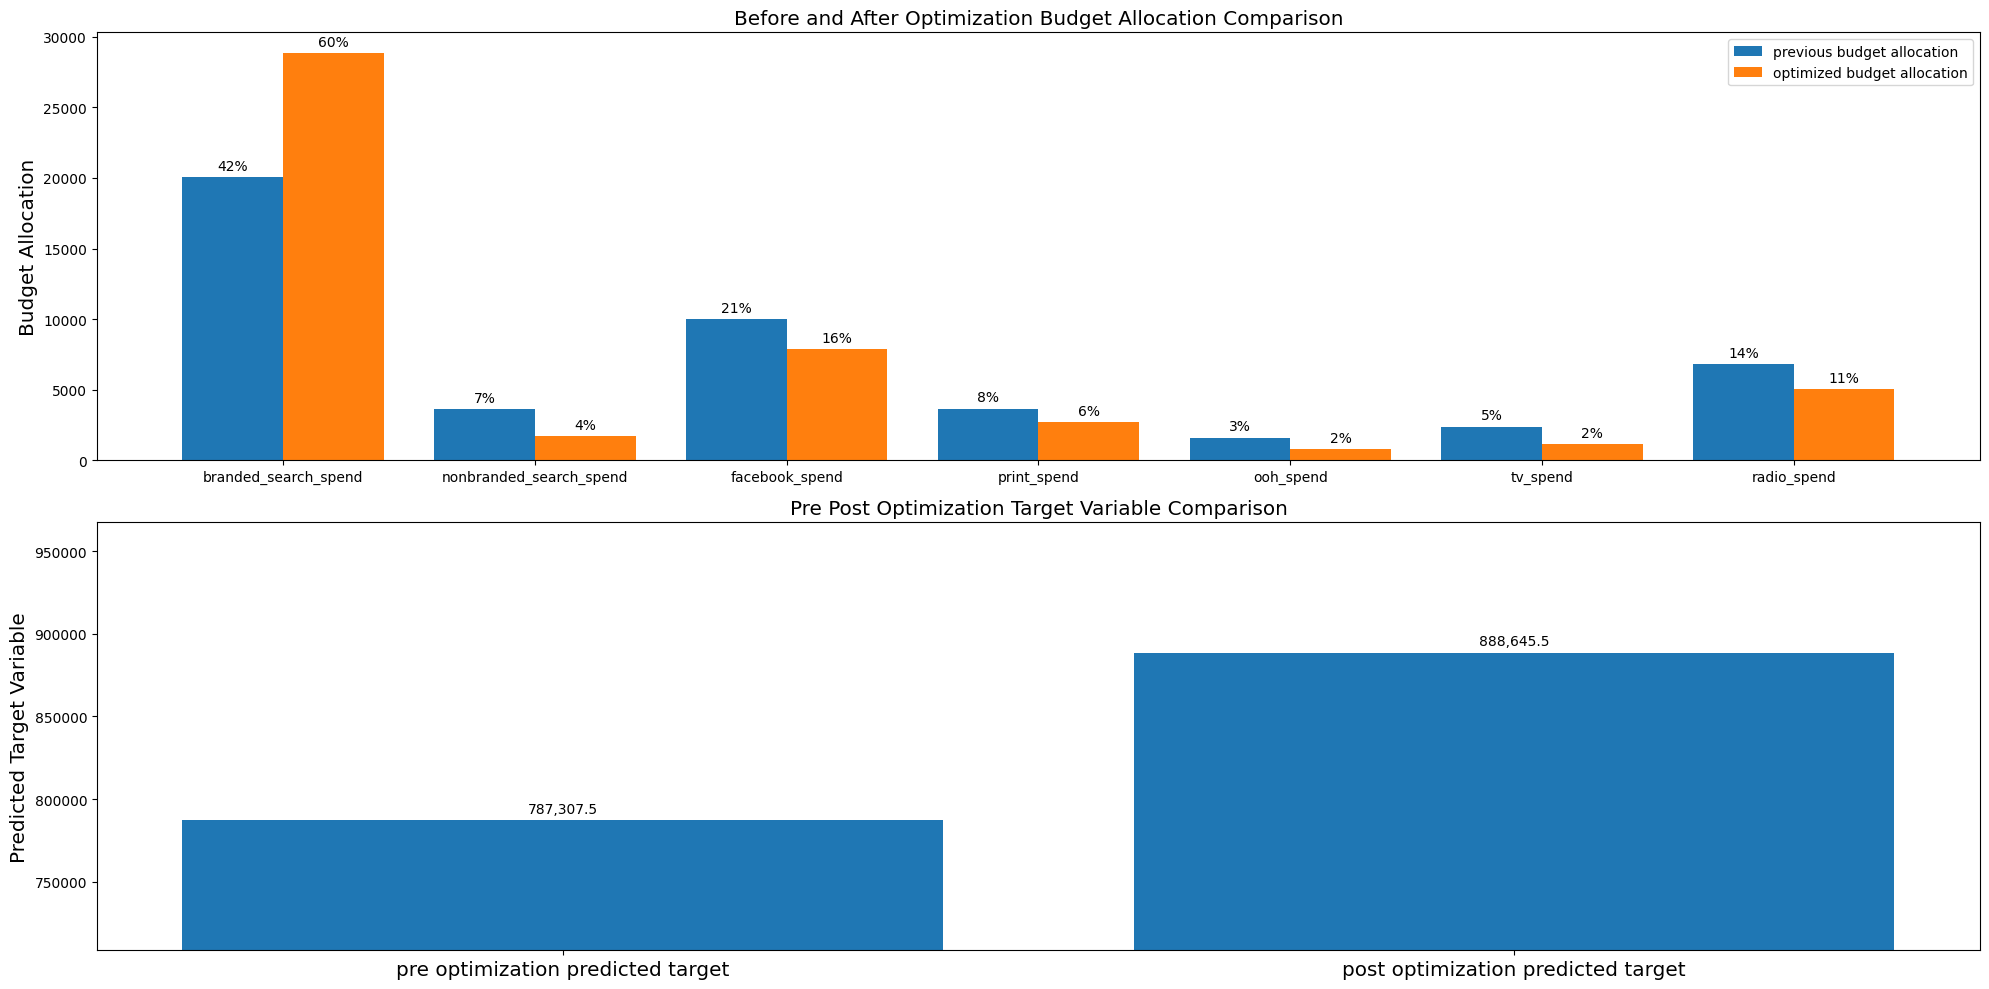

In [38]:
plot.plot_pre_post_budget_allocation_comparison(media_mix_model=LightweightMMM_instance.mmm_model, 
                                                kpi_with_optim=solution['fun'], 
                                                kpi_without_optim=kpi_without_optim,
                                                optimal_buget_allocation=optimal_buget_allocation, 
                                                previous_budget_allocation=previous_budget_allocation, 
                                                figure_size=(20,10),
                                                channel_names = LightweightMMM_instance.media_names)